# Stabilizing the Cart-Pole system

In this exercise, we will use LQR to stabilize a cart-pole system and then adapt the LQR controller to get the robot to move along a specified path.

<img src="cart_pole.png" alt="drawing" width="400"/>

The difficulty of the cart-pole system is that we can only move the cart back and forth (using $u$) to move both the cart and the pendulum. Therefore, it is not trivial to find a good controller to get the pendulum to stay balanced on top of the cart while moving the cart around. We will see how we can use our optimal control approach to do such things.

In [2]:
# setup matplotlib for nice display in Jupyter
%matplotlib notebook

# a few libraries we will need
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp

# note in order to use the animation package to display movies you will need to install ffmpeg
# on Mac with homebrew: brew install ffmpeg
# on ubuntu: apt-get install ffmpeg
# on windows: https://ffmpeg.org/download.html#build-windows
import matplotlib.animation as animation

import IPython

np.set_printoptions(precision=5,linewidth=120,suppress=True)

## The cart-pole model

The dynamics of the cart-pole can be written as
\begin{align} 
\dot{x} &= v\\
\dot{\theta} &= \omega\\
\dot{v} &= \frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta} \\
 \dot{\omega} &= \frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\end{align}
 
There are four states: the position $x$ and linear velocity $v$ of the cart, the angle of the pendulum $\theta$ and its angular velocity $\omega$. There is one control input $u$ which is the force applied on the cart. We will write $z = \begin{bmatrix} x & \theta & v & \omega \end{bmatrix}^T$ the state vector.

We know that the point where the pendulum is vertical is an unstable fixed point of the system. We would like to stabilize the fixed point $\bar{z} = \begin{bmatrix} \bar{x} & \bar{\theta} & \bar{v} & \bar{\omega} \end{bmatrix}^T = \begin{bmatrix} 0 & \pi & 0 & 0 \end{bmatrix}^T$.

Like most robotic systems, it is not linear. It is also underactuated, i.e. we have only one control input to control two degrees of freedom.

We will first linearize the system around $\bar{z}$ (with $\bar{u}=0$) and then compute a LQR control law to stabilize it. The control law will be approximately optimal for the nonlinear system but should be a good enough approximation when sufficiently close to the fixed point.

## Linearizing the dynamics
We linearize $\dot{z} = f(z,u) \simeq f(\bar{z},\bar{u}) + \frac{\partial f}{\partial z}_{|z=\bar{z}, u=\bar{u}} (z - \bar{z}) + \frac{\partial f}{\partial u}_{|z=\bar{z}, u=\bar{u}}(u - \bar{u})$.

We have $f(\bar{z},\bar{u}) = 0$. 

Next, we compute the partial derivatives of the dynamics with respect to all state and control variables.

For the first two equations, this is straightforward:
\begin{equation}\frac{\partial}{\partial x} v = 0,\ \frac{\partial}{\partial \theta} v = 0, \ \frac{\partial}{\partial v} v = 1,\ \frac{\partial}{\partial \omega} v = 0\end{equation}
\begin{equation}\frac{\partial}{\partial x} \omega = 0,\ \frac{\partial}{\partial \theta} \omega = 0, \ \frac{\partial}{\partial v} \omega = 0,\ \frac{\partial}{\partial \omega} \omega = 1\end{equation}

For the third equation:
$$\frac{\partial}{\partial x} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta} \right) = 0$$
$$\frac{\partial}{\partial \theta} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{(m_p\cos\theta(l \omega^2 + g \cos\theta) - m_pg\sin^2\theta)(m_c  + m_p \sin^2 \theta) - (u + m_p \sin\theta (l \omega^2 + g \cos\theta)) (2m_p \sin\theta\cos\theta) }{(m_c  + m_p \sin^2 \theta)^2}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{m_p g}{m_c}$$
Now for the linear velocity
$$\frac{\partial}{\partial v} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = 0$$
and for the angular velocity
$$\frac{\partial}{\partial \omega} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{2m_p \sin\theta l \omega}{m_c  + m_p \sin^2 \theta}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives 0

Finally we have
$$\frac{\partial}{\partial x} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = 0$$
$$\frac{\partial}{\partial \theta} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{(u\sin\theta - m_p l \omega^2 (\cos^2\theta - \sin^2 \theta) - (m_c + m_p)g\cos\theta) (l(m_c  + m_p \sin^2 \theta)) - (-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta)(2l m_p \sin\theta\cos\theta)}{(l(m_c  + m_p \sin^2 \theta))^2}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{(m_p + m_c) g}{lm_c}$$
For the linear velocity
$$\frac{\partial}{\partial v} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = 0$$
and finally
$$\frac{\partial}{\partial \omega} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{- 2m_p l \omega\cos\theta \sin\theta}{l(m_c  + m_p \sin^2 \theta)}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives 0.

We now compute the partial derivatives with respect to the control command. We have
$$\frac{\partial}{\partial u} v = 0$$
$$\frac{\partial}{\partial u} \omega = 0$$
$$\frac{\partial}{\partial u} \left(\frac{u + m_p \sin\theta (l \omega^2 + g \cos\theta)}{m_c  + m_p \sin^2 \theta}\right) = \frac{1}{m_c  + m_p \sin^2 \theta}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{1}{m_c}$$
and the last one
$$\frac{\partial}{\partial u} \left(\frac{-u\cos\theta - m_p l \omega^2\cos\theta \sin\theta - (m_c + m_p)g\sin\theta}{l(m_c  + m_p \sin^2 \theta)}\right) = \frac{-\cos\theta}{l(m_c  + m_p \sin^2 \theta)}$$
which evaluated at $z=\bar{z}, u=\bar{u}$ gives $$\frac{1}{lm_c}$$

We can gather all these terms and get the linearized dynamics
$$\dot{z} = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} (z - \bar{z}) + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} (u-\bar{u})$$

Finally, we change coordinates to center around the linearized point, we set $\tilde{z} = z - \bar{z}$ and $\tilde{u} = u-\bar{u}$ and get the following dynamics
$$\dot{\tilde{z}} = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} \tilde{z} + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} \tilde{u}$$


## Discretizing the dynamics
We now discretize the dynamics, using $\Delta t$ for the integration step. We have 
$$\tilde{z}_{n+1} = \tilde{z}_n + \Delta t \left( \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_p + m_c) g}{lm_c} & 0 & 0 \end{bmatrix} \tilde{z}_n + \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix} \tilde{u}_n \right)$$
or equivalently
$$\tilde{z}_{n+1} =  \begin{bmatrix} 1 & 0 & \Delta t & 0 \\ 0 & 1 & 0 & \Delta t \\ 0 & \Delta t\frac{m_p g}{m_c} & 1 & 0 \\ 0 & \Delta t\frac{(m_p + m_c) g}{lm_c} & 0 & 1 \end{bmatrix} \tilde{z}_n + \begin{bmatrix} 0 \\ 0 \\ \frac{\Delta t}{m_c} \\ \frac{\Delta t}{lm_c} \end{bmatrix} \tilde{u}_n $$

We now have an approximation of the dynamics in a form that can be used to compute linear optimal controllers (i.e. LQR). The controllers we will compute will be of the form $$ \tilde{u}_n = K_n \tilde{z}_n + k_n$$
and they will need to be transformed into
$$ u_n = K_n (z_n - \bar{z}) + k_n$$
to be used on the original system.

## Simulating the cart pole system with arbitrary controllers

Below are a few helper functions to simulate the cart-pole system and display its behavior

In [3]:
class CartPole:
    """
    This class describes a cart pole model and provides some helper functions
    """
    
    def __init__(self):
        """
        constructor of the class, takes as input desired discretization number
        for x (angle), v (angular velocity) and u (control) and the maximum control
        """
        #store discretization information
        self.road_length = 3.
        
        #gravity constant
        self.g=9.81

        #integration step
        self.dt = 0.01
        
        #we define lengths and masses
        self.l = 1.0
        self.mc = 5.0
        self.mp = 1.0
            
    def next_state(self,z,u):
        """
        Inputs:
        z: state of the cart pole syste as a numpy array (x,theta,v,omega)
        u: control as a scalar number
        
        Output:
        the new state of the pendulum as a numpy array
        """
        x = z[0]
        th = z[1]
        v = z[2]
        om = z[3]
        x_next = (x + self.dt * v)
        th_next = (th + self.dt * om)
        v_next = v + self.dt*((u + self.mp*np.sin(th)*(self.l*om**2 + self.g * np.cos(th)))/(self.mc+self.mp*np.sin(th)**2))
        w_next = om + self.dt*((-u*np.cos(th)-self.mp*self.l*(om**2)*np.cos(th)*np.sin(th)-(self.mc+self.mp)*self.g*np.sin(th))/(self.mc+self.mp*np.sin(th)**2))
        z = np.array([x_next,th_next,v_next,w_next])
        return z
    
    def simulate(self, z0, controller, horizon_length):
        """
        This function simulates the pendulum of horizon_length steps from initial state x0
        
        Inputs:
        z0: the initial conditions of the pendulum as a numpy array (x,theta,v,omega)
        controller: a function that takes a state z as argument and index i of the time step and returns a control u
        horizon_length: the horizon length
        
        Output:
        z[4xtime_horizon+1] and u[1,time_horizon] containing the time evolution of states and control
        """
        z=np.empty([4, horizon_length+1])
        z[:,0] = z0
        u=np.empty([1,horizon_length])
        for i in range(horizon_length):
            u[:,i] = controller(z[:,i],i)
            z[:,i+1] = self.next_state(z[:,i], u[:,i])
        return z, u        

In [4]:
def animate_cart_pole(x, dt):
    """
    This function makes an animation showing the behavior of the cart-pole
    takes as input the result of a simulation (with dt=0.01s)
    """
    
    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(min_dt * 1000)
    else:
        steps = 1
        use_dt = int(dt * 1000)
    
    #what we need to plot
    plotx = x[:,::steps]
    
    fig = mp.figure.Figure(figsize=[8.5,2.4])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-4.25,4.25], ylim=[-1.,1.4])
    ax.grid()
    
    list_of_lines = []
    
    #create the cart pole
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    line, = ax.plot([], [], 'k', lw=2)
    list_of_lines.append(line)
    
    cart_length = 0.5
    cart_height = 0.25
    
    def animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])
        
        x_back = plotx[0,i] - cart_length
        x_front = plotx[0,i] + cart_length
        y_up = cart_height
        y_down = 0.
        x_pend = plotx[0,i] + np.sin(plotx[1,i])
        y_pend = cart_height - np.cos(plotx[1,i])
        
        list_of_lines[0].set_data([x_back, x_front], [y_down, y_down])
        list_of_lines[1].set_data([x_front, x_front], [y_down, y_up])
        list_of_lines[2].set_data([x_back, x_front], [y_up, y_up])
        list_of_lines[3].set_data([x_back, x_back], [y_down, y_up])
        list_of_lines[4].set_data([plotx[0,i], x_pend], [cart_height, y_pend])
        
        return list_of_lines
    
    def init():
        return animate(0)


    ani = animation.FuncAnimation(fig, animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

<IPython.core.display.Javascript object>


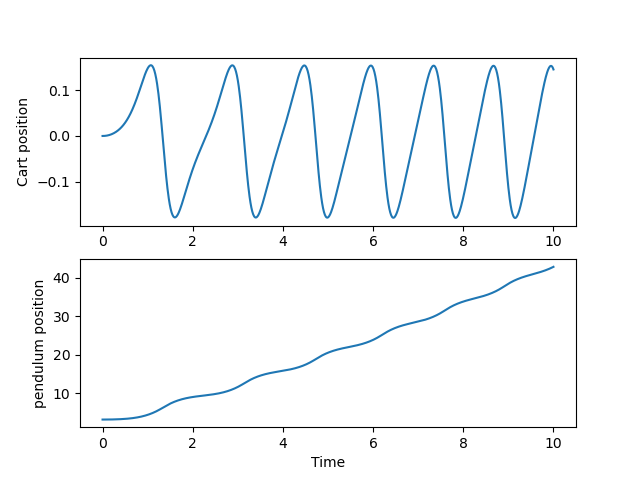

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAf/ptZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1OSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMTkgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAD4JliIQAP//+92ifApta
Q3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAADAAB1oWGAKaHP4R4lcQHw3p8gnsmuEhX4031cd/7I
rod5MvFWiHCxVwOjlEVCe33qCA2PNO5b9t5D0J6Dd/0sVnlk+hpWN2YAqA3v8ZwqvSC0vTS4KRW/
ULncn31ew0lL+AyH18ZHvyMoaqItBimdzt+DoamaNrYnA+6umRcd+XWCkMID+eIZGJCs8uW3Y48H
TlCbvcqoP+0eY92fCJyJQ9PI587pmTTslpyIQjpjNvVTe6vhkMJSe3HZITLydbE0naniEBmGaqZp
5wuMh5JxTCeb0TSxLAo9S3WTsDgHlQQ/YIF5szkGtHm3PHLyCZE7Be5AAjP7soUJkyEcnKvsxfRt
i/ogvaA+UyZWkTZ88k+9xB0W9zh7VViLyekUkiAckWg51fBJtzCEazY0IEcTSmyWTfyd1o3M4VN4
gp2Qa94arDJo9doPaWitujrCjytOtynWlQFsTcIOB+8SwhNvHOb1wQO4UFB38M11jBVtHnW3QoJi
Qbmy2RlO+iO2W22yG+8s3OQpZ1jeYq9jiCJLOgODxmx5IDqVOAKQr0ONM6LXTwsIv2ClXUsxecov
aqrmD/Iu/hQ57incgiJtUmgMHPCEC5IwCXStFqj226kl9KWgeRLVM1+z00sSDIZT6TZARpWIzkOT
YHDDWL6wkizQ9t+L7yTud6bvCzXHZTfwRaSpkphKTdL1CxDIGDR9owVkmo3BosW+0BvugL8wiIxf
zDs+Wyg/5p6RhdSP2eC/LEd/C4H9Oyil9s0d4/JsGFqfQUa74qczjs1aZgDum1MZHOzDIotfPNPB
0ihDx1fuCWKWPSaHPHfkZqDcwofpSpj0glYOybKmr3pTAgJK7YFsms1FyItaqWJ5neBr2njmJedT
R6f7nLQZj6w8Tt5F0vF1CAP51KGfTRH6jJ+P6kcthXeXEd/Z1ImxWVfvoMIrJ8fpblwwL5FtMR7W
LhbOUUyaG1iIQcUEYb2m2Js8AAASYsrasa/PPO5AOdOx9aJtLo7/+jDqOCaBFiVIjqT7Ta0uucC0
3hcqmZ7FUtQWd7zoF8RZ02y9BAUpvOjqGIJG/UbdgnIas7oVcbOq4B5hvpKwWuox1ZQI6W0daAyM
x+Xr72FO8KOn9JO/9iqH4nzL28/DTWTNAFg3mX+kj+ZisWK+mg7hNLvpIa+X0j3iP65FcFpk7byE
BIAXieulWVKXF8Vjf8CKk6Co4TjT59r5sV7+MBErBcO7OpzkrU1YZTnByY/ouFPj3zgw3ro5cRgh
ESAFiLljXqhoDTmAAizu4alxTbWDmI0t2zbN0TVXrABbZpSZM52hug4wVeoncdsEEfN64JmSX1rS
92QWmAAEQ6ccLD7Ngrljp9aMm5U3gYaDmsb+x06DhqoA0GPsbROeUAQGThE/T4JgxwPHa6gdpPBT
gjWUlnjCzAOq2gBRlrNg4C3GPnn8wHAEgQFypYEtjS1c0d07qQhTjlffEKmq2bQbMY8zR0EvPlr9
mMpgUqlAUsgW4bnmuwkvjmmw7wSsJ+lmSckAw+NTJj4b55IGcr7+BRWy0GRLssg/r9Sx/yJvDsuq
756DCndh/vf5lJ4Ar+ZfpswoYuf/G78NqaL3TdUCuW71YRxUsbkZYd8G/vKYbBgDBlrBDgQzLmD+
lW+LXpP09jRmCIV/jqi3waX5f5qC4smMfA6rMdRIJpLhzWoQ2vjcmZN9O+15FENTUwjv3FDuoH3/
JqyKL88e69K+oHdF4bD9sUk2xs4ykIN66Hq1MqBseOhEFHKIGCKooXC1IGR2bxqwoszPzSaFJHiH
uYv6LHKeFPGANnjOGhb8sYfPAApuj9UOaHXj9WQJrwNWIx0DJTLfhDbzMe7h741b6Slwq2KwLlrc
DybvhxPShSkwpk51n+jscLaRtiiimEwX426W644XbdKgfeEfTFeg51jsMyNxCNMM9o75+HaJLmxj
4rvYjTvGHmPBr0j1xn/BpCF2iTnA9JwX0KE3Fznmx/v+n4e9RF+9gPqnGwYjd3oAAAMA72XRmKCV
NVN4ZT1nklraqCUzE71ZIgDfrFiQW7b3YtuvVEP8+Wyv1M84Zf6hi+szo9wNfRpjbyPIs8+7TOFs
s/c2/FNPzhYod4LeM5f5z9VBFzWyJeHvyXEr05uFoad5ipnbUvM03zg7tdkPjSi06Zvrm/iEf+qh
ZFlnn+xwbgPiycLEwxtc3uKyIDKUZuUvOk55WcCLJ4xoIEHCtxkh8epmxkvrN6jtfyQnwddYz2wo
lgck8/rEDDM02Wn6G+7n4MdMFU9BxTxNGtecnvp09Pw8XijXgvhy+qXDr8wJakm6eoRnRomQJ0UB
nfH/S3LTap4a+gSjnZhuAhF8R8DLeo+cHIdL6En93zfubjKz73H3vqrEWng8wXSyUhfEsGesMuWd
T56Tq6xsK3sERgzpgiaqfSFPD4ctmPjxoIUtrfuI9iZcoqATMDhCtBcRjYf2/adGOhsFRzcsoCyx
1H6q0PjlQSoU6Pxxb2zABLGLCyrqqqSJZdtAe2n03bYpdaWO8uKjlD3aO88NY421n5WHQXmSiIze
7o+OE05OsFzKuv+aIMxHx9mRlXGeP0GHKQRvvcsY/vKD5AAXcn/I/qmfLtUi9qoOhENAAKPfOfsK
ihP0qQgbz+0r253dtMfXhjxHFKs/ed89DFga50BnFlirHV8TpTs8nIanLcxYhmPCVAewaSR4laJB
tQLJ9rTb9thyy6SRLvSPvecCIT4rtRzRcr3/9y+c2lTGNRSSZ62rFj+EANbcnmW6cztor3C4zFG6
jplbLEsokD/3caQ477cyOa5p3bq+C3YqeXViRJ/34oRr2xL92DUUjmyvxKiThQ0O8P3RtZv6CR1Z
4bkJR7xfbPgXs4QytKXs8

In [5]:
# we show an example on how to simulate the cartpole and display its behavior

# we create a cart pole
cart = CartPole()

# we create a controller that does nothing u(z) = 0
def useless_controller(z,i):
    return 0

# we simulate the cart pole and display its behavior
z0 = np.array([0,np.pi+0.1,0.,0])
horizon_length = 1000

z,u = cart.simulate(z0, useless_controller, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(2,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')


animate_cart_pole(z, cart.dt)

# Question 1:
We would like to use the linearized equation to compute an optimal controller that stabilizes the system around the resting position.

1. Write a cost function that will help stabilize the resting position $\bar{z}$ (be precise with the variables you use).
2. Compute the infinite horizon gains to stabilize the cart pole system
3. Write a function that can stabilize the system and test the behavior of the robot using $z_0 = [0.5, \pi + 0.3, 0., 0.]^T$. Plot the time evolution of the control input and the states of the system.
4. What is the behavior of the system when starting with $z_0 = [0.5, 0.3, 0., 0.]^T$? Explain the behavior.

# Question 2:
We would like to use the linearized equation to compute an optimal controller that makes the cart follow a 0.5Hz sine trajectory of amplitude 1 (i.e. $x$ displacement from -1 to 1 meter) while keeping the pendulum balanced.

1. Write a cost function that will help enforce this behavior (be precise with the variables you use).
2. Compute the finite horizon controller that creates this behavior for $N=1000$ (i.e. 10 seconds).
3. Test the behavior of the robot using $z_0 = [0.5, \pi + 0.3, 0., 0.]^T$. Plot the time evolution of the control input and the states of the system. How well can you track the desired motion?
4. What is the cost value predicted by the control design? How does it compare to the real cost value when applied to the nonlinear system? Explain.

In [6]:
# Creating fn for A and B matrices
def AandB(mp,g,l,mc,dt):
    A = np.array([[1,0,dt,0],[0,1,0,dt],[0,dt*((mp*g)/mc),1,0],[0, (dt*(mp+mc)*g)/(l*mc),0,1]])
    B = np.array([[0],[0],[dt/mc],[dt/(l*mc)]])
    return A,B

In [7]:
#Question 1 Part 2
#Creating Gain function
def Gain_1(A,B,Q,R,N): 
    P = Q
    K_n_list = []
    P_n_list = [P]
    n= N
    while n>0:
        g=np.dot(B.T, P).dot(B)
        D=np.dot(B.T,P).dot(A)
        K_n=-1*np.linalg.inv(R+g).dot(D)
        K_n_list.append(K_n)
        P = Q + A.transpose().dot(P).dot(A) + A.transpose().dot(P).dot(B).dot(K_n)
        P_n_list.append(P)
        n = n-1 
    K_n_list_rev = K_n_list[::-1]
    P_n_list_rev = P_n_list[::-1]
    return K_n_list_rev,P_n_list_rev

In [8]:
# inputs for Gain_1 fn
A,B = AandB(1,9.81,1,5,0.01)
Q = np.eye(4)
R = 0.1*np.eye(1)

<IPython.core.display.Javascript object>


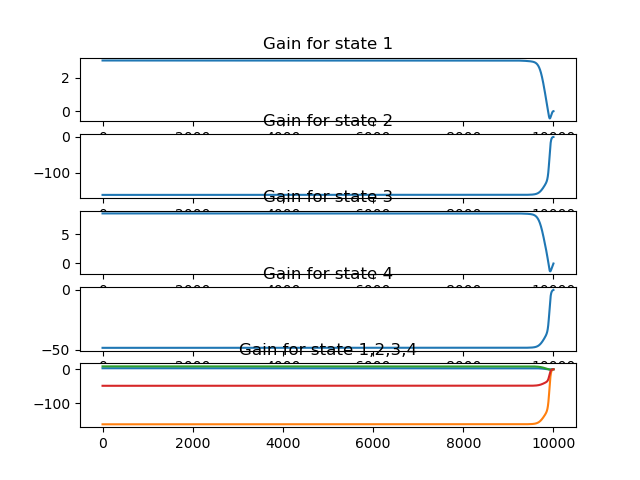

Text(0.5, 1.0, 'Gain for state 1,2,3,4')

In [9]:
#To find out inifinite gains using horizon lenght = 10000 as gains stabilize as horizon length approaches infinity and can 
# also be seen from the graphs plotted

horizon_length = 10000
gain,cost = Gain_1(A,B,Q,R,horizon_length)
g0_list =[]
g1_list =[]
g2_list =[]
g3_list =[]
for i in gain:
    for a in range(4):
        j = np.empty([4,1])
        j[:,0]=i
        if a ==0:
            g0 = j[0]
            g0_list.append(g0)
        if a ==1:
            g1 = j[1]
            g1_list.append(g1)
        if a ==2:
            g2 = j[2]
            g2_list.append(g2)
        if a ==3:
            g3 = j[3]
            g3_list.append(g3)
plt.figure()
plt.subplot(5,1,1)
plt.plot(np.arange(horizon_length),g0_list)
plt.title('Gain for state 1')
plt.subplot(5,1,2)
plt.plot(np.arange(horizon_length),g1_list)
plt.title('Gain for state 2')
plt.subplot(5,1,3)
plt.plot(np.arange(horizon_length),g2_list)
plt.title('Gain for state 3')
plt.subplot(5,1,4)
plt.plot(np.arange(horizon_length),g3_list)
plt.title('Gain for state 4')
plt.subplot(5,1,5)
plt.plot(np.arange(horizon_length),g0_list,np.arange(horizon_length),g1_list,np.arange(horizon_length),g2_list,np.arange(horizon_length),g3_list)
plt.title('Gain for state 1,2,3,4')


In [10]:
#Printing Gain for state 5000 as we can see the gains are constant as horizon approaches -infinity
#which will stabilize the system
print('Gain for horizon 5000 is',gain[5000])

Gain for horizon 5000 is [[   3.03907 -160.86331    8.52613  -48.2531 ]]


<IPython.core.display.Javascript object>


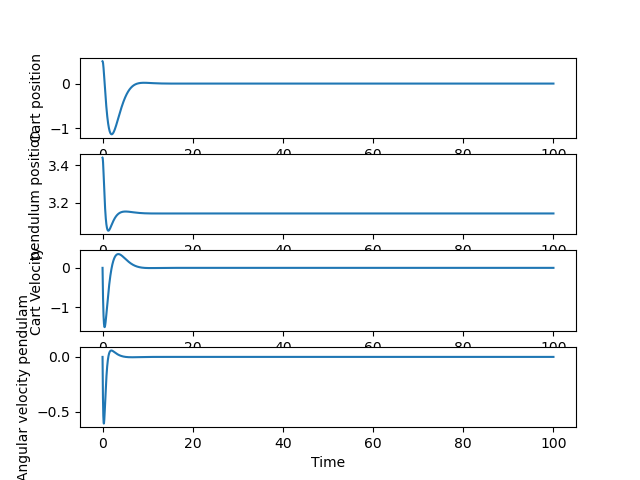

<IPython.core.display.Javascript object>


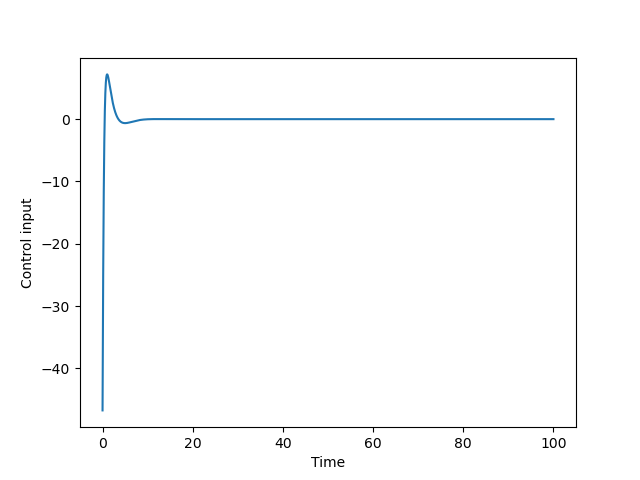

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAzyltZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1OSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMTkgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAD7JliIQAP//+92ifApta
Q3qA5JXFJdtPgf+rZ3B8j+kDAAADAAADAAADAAB1oWGAKaHP4R4lcQHw3p8gnsmuEhX4031cd/7I
rod5MvFWiHCxVwOjlEVCe33qCA2PNO5b9t5D0J6Dd/0sVnlk+hpWN2YAqA3v8ZwqvSC0vTS5JNz4
xRC1mjfVKP8UeA1btXfwZ5oFdH8OwR2DF6cWA2o4ap4Op91M0rEhjWyDxYt83yak1PDcISMy+i3j
eYRfUhYf6rMXTLZmIAvSeNoODy7S+D736xMeRP1c0i4sgweDTy1P/Ny3KU7U8Q1zQbsGqScLRXds
s3emhOmL4lgUepbvJ0RQJAVwk7rGJcpvVNWI+M3HSrlY7Da17o///rf2WuCiPdSVvQMbDXxEs9sh
YdW3SwCbVoQANtzr5ea5tg+Z5cKveaYw5YcVgL4hiQk83Yc+ugiBH7ntIus7GrZUQ3q+Cw6Wj4+z
bI1ujDo1/lD8roWoyJr0mN8eePh8ud6DoLhdpYUIHPX+hP2BzM1TC/1051hHSSmAQabeaNmciv9q
vZ8xezkAaSTsIyl1+BFEgLVM3TIjzQwANgx8d6BHJnwOCv7foKPMY62BLZQULjcJoFAdXyxCifHH
Mt4fdRsx3WiSAoXS9q/sBFM978sgJp2OcHY5lxAN8wPsL9XbLXxmRv8LMH/3AtJUyUwlKAop6Knq
FzR2r3sN++0AE9tBnlTrRfq8ZZRLQf2qZQFrSe11h88aQoneNEUuZ5twnJWR8UpL8rLMVo+ImUzS
/Wq7ywLv8nah81/qHwfMPFrbbjOoW5VT3NA8IxnTdnWsm99dbOWFUXvN1ao0T5dd/X/BMOLg9SrC
wnnKlYTyMNKAKpoEffPOw0Kz2S6S6RBZkDnwohrMnT1tsxZBbV8pX+iqJcKpUSOZQoLsIU9XFTWT
lqVf/pX3ivHGMzM4SHvUQmZup/A33UIw0tZND9h3XdyUp+94RMSmuBC/RvqSiLvY0EjDhesCL8na
lW0feiEoAAAvd+ZPhKUpgOeklX7friM2KWv/7gFmW4/BIdKeqCZ3E1C+eOhv457Sdei3dVIifYkY
hDa+Or0q1P/IVeiKG+e11JzoirEIogQsU5SMTF1CAu1vsKwfUfdI7E+XWJN3tu5wUSILhHjm8uHH
dXfpO7l/SpV7fn9R48obvNql1BGoz+f8OkUTpVsLYt1JXcT1DdIGswSp7v1OEnFcdbxRaA7RU8cr
M04Y3X9qWBGbsArczSzXrbRFscI4Dnx8WogTt55ThFzQyaCad6Y2tSigra3I/8holcMDm2vhakMO
wQktM9GANOux1TiK4gGTvwBgmoqNsOg5KSFZpumSU3EjE3DbBNpgoH+V/EeePTkMwaNZcgaXDa3L
dWznmRf3ymqrklV+jiXEz+eZy+6vD+USHl0pzWzSox5qQAjI8IYV2crmwUWoHkkdhBVhT41kuN1h
Z3ae1RNC/nCX1Yg0aAycIoR53uoxVcQ9TSGAeHJLdDSwmEWYB1W0AI5b9W9ql7P/yP6kN0i4VNMO
ou1X5IDkc0MoaT2hN9utdrT9zws6LkhfUJJOrsvaGg9h8BdlV2Seea7CS+OabFjvywrEFhizMtDT
2hbjGvZgqXJsxvJFX10uFafeW1T+vMICL6zA+PhkvjdW0lxRKVBy5ql+gUQBSH/8F03lKhLMK4yT
sTkYPvrPiXRh58whXfgTxxR0OPg5EuyB51fyCw9JEwz8KZswkKcPM8Ekm+yC4wMvPPf7HBb56Gv5
N6YNgOMUCL/cb1XtuPImcIl1qxBKDRe67HLTYNq35X5y99GHvj0dtiDRVfCy05jhpN2muLOMIn+V
tLzUqUfuVU/5K7ZDc3oVPeRRmoTKCoB8vU99jD9KhVHaRjtSsCyH6LI0G+X6qHd4gG7N9y+8vPUr
lkrGIV1MREtJPAsFaPG51BshCjZy8MBrWpS7p7Bl8XCMcrQv8h8TT0bnpyJyYDNcdnuV+4+OyTUA
2HvBEPoHX0dv5iGtf0k6J/cvccYa4xvIcnkzdoAACRYEBHrRVeZmwxvdaAJvDRYdbosFoEcwh2Pu
i8qps3HYvq2OBzUCrRF4US+TvPyXbeZ4gpr/+QqcWy9ohpLxF6iw6A5MYBVzbBfqpqby2El9QRtA
h0d3NW+XEl3wtiT4RkprFPY5dVtfQHQt4fU/ccFvNnR3/ej0+vHBEbKvLKXcF2m2aV6ifrbgOXwD
x0FE4lwKwgmjgNTguGoDdM2Bh8tS2FtsBQG5r8A/aLuJkIod2+ZJCVPIx1VFxgavvTY7E+dhnlk0
Zpx2T0deadFUn0seqzlM+f7tT1NR0BC7lGuQZSpy5WWyJ52q5ZJJmIeEJ8HXWQC4kmou1sX0Mml1
pJoUArGMoiQkIVseyj28dBtRNdxEG+0C5eWDxbVdxOk6ryURC/DPWjo6KzLEZQA2vj0jnVhSPxay
BOadVRmvQi+I+BlvUetpb+fw0fXcZ0F7ksvnBIYe42YmFCTzbAI/wHGi5NXr5wsjsTtEqgxaPd1t
d5L4StsPXjeIHPKryKgFq6H0ux2N8BAl2Okk56/x2M3CJpV3dSVrW9snoiIrVrsvgQRsVj97YQDU
daik36gVFtSOPtyqkKO88NY4teGAtQAgyJPB6Ix3HPl0R6wXjj+Nqs0AcjcCHeBA86OxwcavN2cC
hwf8/oObvAuMI6v/ZaXaCOnYN8aAxuBUMPyj2LXG3gNyPTV0E9o+iWrAUb+vFCooqSlT/j6RvgNW
P1Modw9vCbDMfzVcyGh1N3C4tyzXjOW+SlYGydfz1PpIyJajQ3EkSNA0fCEiYF1U358EfQpZYsbn
xXajmi5Y26fcqtRoCDJ8m5RGPPgSQZoFbcnmW6cztoj3Mm6JjTe+yKpJ8RRnThh55zWVVEjmuM5R
0eb3+HDcGY5JxD+zCNe2J

In [11]:
# function that can stabilize the system and testing the behavior of the robot using  𝑧0=[0.5,𝜋+0.3,0.,0.]
horizon_length = 10000 # setting horizon length is equal to 10000
gain,cost = Gain_1(A,B,Q,R,horizon_length) # getting ains using the gain function
cart1 = CartPole()#creating a cart pole
#creating a controller that does take it to the desired position(0,pi.0,0)
def cont(z,i):
    o = np.empty([4,1])
    o[:,0] = z
    u = np.array([3.03907, -160.86331,8.52613,-48.2531 ]).dot(np.array(o-[[0],[np.pi],[0],[0]])) # using inifinite horizon gains
    return u
# we simulate the cart pole and display its behavior
z0 = np.array([0.5,np.pi+0.3,0.,0])
z,u = cart1.simulate(z0, cont, horizon_length)
t = np.linspace(0,cart1.dt*(horizon_length),horizon_length+1)
# plotting the states 'Cart position','pendulum position','Cart Velocity','Angular velocity pendulam'
plt.figure()
plt.subplot(4,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(4,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')
plt.subplot(4,1,3)
plt.plot(t,z[2,:])
plt.ylabel('Cart Velocity')
plt.xlabel('Time')
plt.subplot(4,1,4)
plt.plot(t,z[3,:])
plt.ylabel('Angular velocity pendulam')
plt.xlabel('Time')
# Plotting the control input 
t = np.linspace(0,cart1.dt*(horizon_length),horizon_length)
plt.figure()
plt.plot(t,u.transpose())
plt.ylabel('Control input')
plt.xlabel('Time')
#animating the cart pole system
animate_cart_pole(z, cart1.dt)

<IPython.core.display.Javascript object>


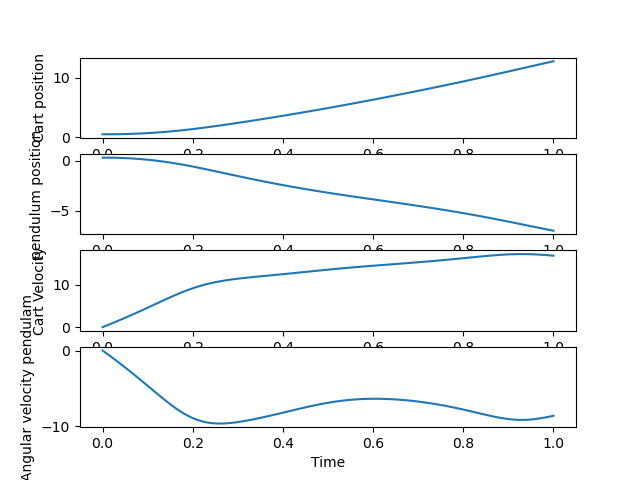

<IPython.core.display.Javascript object>


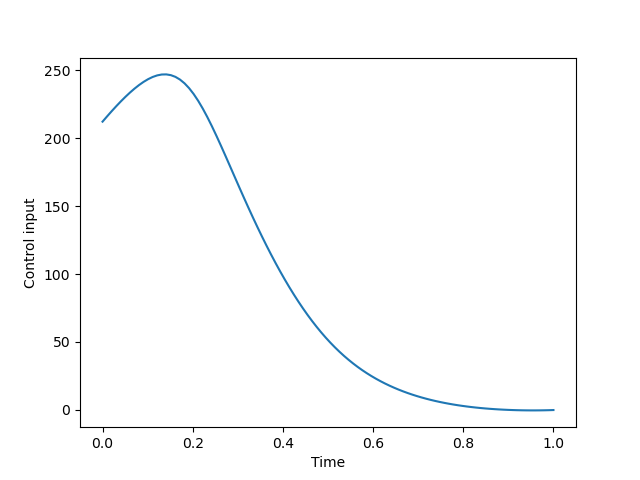

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAGDxtZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1OSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMTkgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAADo1liIQAEP/+94G/Mstf
IrrJcfnnfSyszzzkPHJdia640AAAAwAAAwAAAwAGIxI3/ong/hHiVxAFW+wgJ1Jh4Pmeouuzq818
RLQWhlrYmXPwhhjWSrmxgg3LbIlZgouT5Jz+B9iFICButJaGBgBJObTbXrZ6OatjEI1NLcL9B/0i
NbSxh6Q4bshvlWglYtHi5Zbh+GphzHEQDpcG3oWTDB26fCdYeV3ZTJwq0vT+Um9uYPmWjzTfVzKv
1doJdTG8Lqct4KpXdYsufuuleF+lWKhr7Aw79j1Tjk0xbRi8PLrWROl9MSL8rMBcEFVYkrWeFZJB
Zyh7SmOxGkmGkwAYfqXb9h367AYvk6L/vTgjInFgAQsBUr48EsHWHBjvYKvCXSPNl6cAtSuW+M7x
PJz1mr5g2zGuYyjEDOwdGSWu1iSPiB6mMEbawtaAX+KBUSeckdhceBhVpH71l9zRev3I0RLrjfOd
k3bpQTeSIZn9GQzVVNv9QaoeNssKXQ5/EoxI8Z4wBBSZR6YMYJ5n86x41ceLsg8cugigOzimnJZ/
O5NyjKtDFnoXVtRD5gjlocwyWjHbWdaIucEtdFVlHE2LHORiE9+v8YKmF7ov/KhBY7CPjAuViYx+
2wNddIkkJz6on4ekp0Bn+xaFMzTMEYK1U3gFHtWAkea1q18WnPGuuMn8v+jyVIChf1J7Z89YvKO1
XKlmU2eTfQkaKMu9Cg6FzcZRRElRtNKUpdHpRCihl/TH1x/nQLW1kn/dDnuE9v7v5uqhc1BD+bPA
vV/E0yv4qZxYWhxq/xOFmbdplTLvHE2KhLe+8sC998L5ZlY3KPQKNjV4CSSwYK65MizCYKXifrLE
S2Ih1vqpKAahsvYy0JjrVNRkdGtADXWBfqo8j5g/JBHdgS7neB7bf0QI+249T43lY19mWU0ach2n
qqjknwnjIkGpMhOPkNJEvgyeQd7n+qi2AASI3Qg3lmZd075iw0mwP3FgRIYU/WI0iqdliPJKxMux
MCf/qAAkkcCZmj5tTNxWUb0XkDynDjQjmkqT4rXfImlWLYcYejLbej4cwauzNxOy4uPBeN++z4bc
4UkkyKJGYKi4mriXOQTjmXfNmx7gm1oh+xB0bMH5vTjlxsPluRxFyhOaeaJ6nlccW/lhHIfgCla9
L6GPrYESiyFC3rrNYeEAfLcKC1JnKl9I43FyZl6yAq3MpwoARIk/YBJhTJ69a6G9t9y75UnN1kv/
TJtFD/EFX14C0VdkuvDjgJdit/RBTF2H/RD6Wot4eZ2H1ON9LcGzVoTmyem0/0BNgCj+Iv////W/
FZA9mff99EezI1aNrI2SCtVmXtcO81Byjp1CFakU77cD/pg7ICvbV8FHHGxNskoXj85stDuxiG0G
lj/fF09PVnOrxB5c9QlajSdqsusSu8xh1O7LRBzYXlyfJoRSjdv0yKdOXO9z0ODPcm6V1dEQW09V
pVJz7d/+MYkQnKLJQk+L21fw4TkKXSbq4w3+WdA2a+CEdXxwm8j+3DbyZ7EU8938glisLSlMsvsj
0TiedcUFILhQH96V25Q925s3FT95fUqh5ToMUjCeAAAXVypNtadk7vIOblpyhpWxmfgAcRIt+P0I
CCgkDd7fj0J9bIMlDZucLbxW51q2EA8Fo3cEFbqRUeRrnvK9ezWvIIeCebwDCwYGAv2kXyT3YEDA
kGEbaUE9v1OaoUqDi5ZTZ6EDmhoC7zlGe4B6JqS02fZ/WjhYFaRTubtl4xr7Nh7jOeaEelgybibF
Df4G3DwfFsYgROORPx3/BpPW5B9GF76+Ge1do4tz464oc1YVDIp9FdJeyJavv5ONGlSFhDnJTcPE
4P94j5mm0dzGrdpMSRCZfz6lFk7PBH3TppjlLAwhvpcCjIcgcB7BwdiKx7FKZ83pF4zCQGkFNwjE
NO3tayhEaUh0g9TB30MslVPJuQbO5yLVAIDDq3Y/sK6tqmcDVnrQ8ape7YWCyUC+UrYNlelbq2XV
kU8hYkyrRRjq80PMSiGivqW//KgWwQK7yr3z6H2V3eO6hFo+d6o45sBarPsp7hWD9LPX6S62jxK7
+BA+wa+TP/ge4cXOXSsH3yNn2ZKb5fgJgat58WgZUxoORIqu3UxFcEYu+sVVwhlyoS7QWP3mxq7t
BiW3U89g3CQPUQPfB/d2kXQZ9khZdGen08vKpaBxU/32Wms9VGgotZ4+iMyl+821vEC9hfpQ5b9H
MUEmzu4UM95V4VgQx+nTcBEuAbxyciJzR0a3G8tlSLNTK86sAH7Y5xZgASGlg+Kx5yiyCTB4mBUX
2GhEzXaNWvtGl3L0JktXpohX8Je+nn3Jqz8LkgxcLh/WvVec+OXaPZB2A1i1D0PzUmAtug5O7s8p
Yn8ck7rQ338Ch4MFqubJW00ExYFAEd8EgBdMulgg7br6nT5ABVAFinuhRtSWmNhAp06LDNXFscwl
K7TETrZcLpPL9OkF5rjJtXJFP95gx0uPY4Q6v/8+hdGJ3bY35MehUNSrEqSO7nbCsKk4kKA5ugXk
3PFCewVGWFkiXQFR/CiPn9LGtGwiMZyCqzGzPHs0B8k29S4nD8zO28w9DQGe4WYvsGcfYBgKbpb/
8+YI4ps6qw+uJl5spSp+eW1MVe3nTQCPsmvV/eHN8hEcQsHXV5CHXmOxY3pq/VKZb3uvvn1dOZPs
HTDSN7I6C8pVdS0H4WhizTqD7nlhWCc4Vx+2azTO1Y7+5MqdAGksaPHTWPgF1XMO2fiIusNYBxKm
HaOdw5OBRpvh2amwBWNYc1Ohll3N6lYignS0je2G+hIstaPsjSgNSqt6Q+GyZ1vlo+zDzpo00L//
OujQuMj60SfcGH7MT0rA/mBM0DbOBg6PVkwBRqXeS3h1WhMIqYTWRkF78ZpqPlH+5DLAAgPqOPWx
Lz7V3gwqUt5XCvqXeKoL3

In [12]:
#ques 3 
#the system diverges if we start it far from the linearized state!
# testing the behavior of the robot using  𝑧0=[0.5,0.3,0.,0.]
horizon_length = 100 # setting horizon length is equal to 10000
gain,cost = Gain_1(A,B,Q,R,horizon_length) # getting ains using the gain function
cart2 = CartPole()#creating a cart pole
#creating a controller that does take it to the desired position(0,pi.0,0)
def cont(z,i):
    o = np.empty([4,1])
    o[:,0] = z
    u = gain[i].dot(np.array(o-[[0],[np.pi],[0],[0]]))
    return u
# we simulate the cart pole and display its behavior
z0 = np.array([0.5,0.3,0.,0])
z,u = cart2.simulate(z0, cont, horizon_length)
t = np.linspace(0,cart2.dt*(horizon_length),horizon_length+1)
# plotting the states 'Cart position','pendulum position','Cart Velocity','Angular velocity pendulam'
plt.figure()
plt.subplot(4,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(4,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')
plt.subplot(4,1,3)
plt.plot(t,z[2,:])
plt.ylabel('Cart Velocity')
plt.xlabel('Time')
plt.subplot(4,1,4)
plt.plot(t,z[3,:])
plt.ylabel('Angular velocity pendulam')
plt.xlabel('Time')
# Plotting the control input 
t = np.linspace(0,cart2.dt*(horizon_length),horizon_length)
plt.figure()
plt.plot(t,u.transpose())
plt.ylabel('Control input')
plt.xlabel('Time')
#animating the cart pole system
animate_cart_pole(z, cart2.dt)

<IPython.core.display.Javascript object>


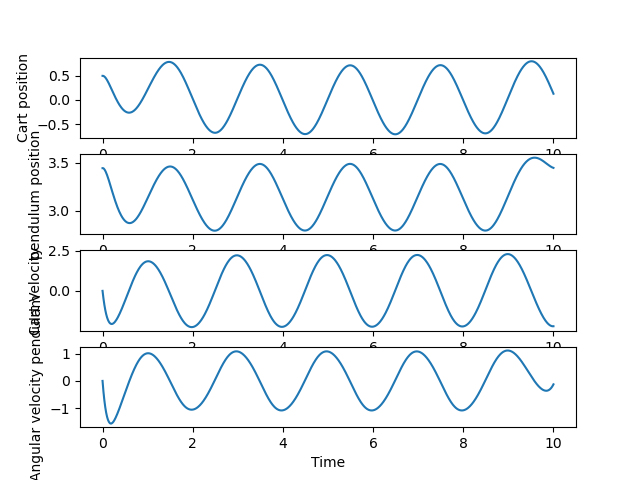

<IPython.core.display.Javascript object>


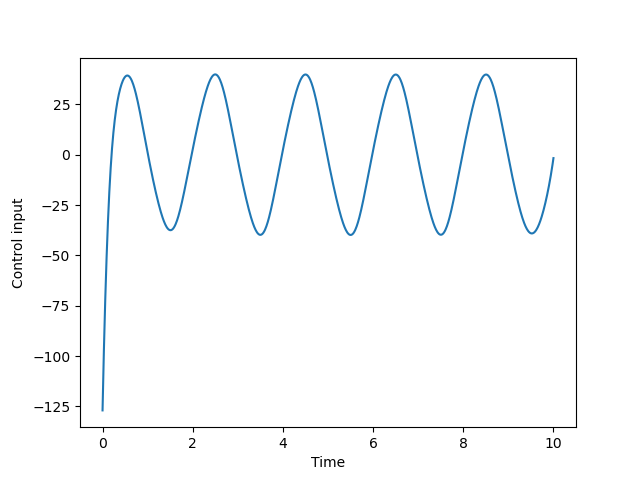

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAclZtZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE1OSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMTkgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz02IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0xMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAD7lliIQAEf/+94gfMstp
+TrXchHnrS6tH1DuRnFepL3+IAAAAwAAAwAAAwAKklieIonk/hHjj4AGwVk9YXrwrxN2hx/R8sZx
6igaJ9nMo/Wp/oYhIv3T+e5hYA7y7seyy1gtJAlXgur+5bQDuzpy1hjmCeP3A/aXIWFi4zQgXyZi
i6hhfk++r2zco7WB1vIrJFF5iVDwmGPZnFVn3F+0Bo2uSRGcFxS2nlbKkz3daf/DhWDCoOtcZIpE
z95yhN3uVUFAb5oWqLvH6jp9pTr5Y8mTTslpyIQjpjNvVTfAysBDyZQrXUq9RPqUmW6kTJjFR+II
hIi554fOC8ndd+Ik38CdT712XQ1xjIMFaJ4+lIXybj9FB6nhBJaXrUM7Eu2+rQDYNFADmrw9f9f2
PQMbDXPwOBNJ+WR8dFFnRgFXn8EsGfb+qnsIs6zwha7dCcNGnJy5B1P1oWY1K3xlrSXQx7yabNw1
vsV87u+DZtSAwY/j7chkKHk0s6WD2mfjXrNDf3SQSj/180f3CLpkku9Qn3uJTFO3z9nIoZw5V2fC
9Y2z83G2vr/BprnWSXcVLeTLvh39MkAirDX8BrbosKsZp1docCwqPFbxyz21GilxwxqBBx0dVqVW
66OAMoZSh01cNV1iwRhiCOJDKP20TxMjZGwuREHvf5LkV3acj3kvDl0R0TRh7WdbFWTwg8l8eGHO
ad51kQ38BTfwRaSpkphKXRbC+C7IAgLTGYyYTOvINFi32gN9z9/zD0sn+W+PLS8+zZd212ehEmk/
aPMoimo2v+lQKh6P/OUZhp+klLzUrjTcuRSzPFPPOii1FBhsrNA9wGGWND//+fKRV8d7amqk+ovV
r1W7vp/QrggAmRB1ZWvGdzQHGiCsbIqebKcayfQclaSISr10Zwq1kz3EkXnI0PilGS2MaMERCNAm
Ax14wBNrgvHuBil25ioQngFP+UYYv7/nx+67AL4EKXsEzD+/cP/+Qw9FgGAefKiKSIDkjzLoC01j
TgcgRHjY89zhrWOEJ+sUX+6stxy5AAADAIDfs42GHlpZAAKktIt8jTuhaj//j+nMk1xXigSGXZ9h
4WsBOPscvWN1nydVVLUFne9Bc2TdvxB5rUZ/x1bB9gJwTmzaqzH4wUDd9yk3QTu7DjQR04oTkrsj
BkcOhWzy9hNOL5+HIXdaR49GpL1y9leQLnGL8pmrvR0fQkZB4eetJF3n/pzgtFqv1NQwO4UrlI3n
L4sNa3vH4Tyl31Q4I+WvFwmcpHkh86jR1Yo8QwALFxcVN6/NilZceZR+McJQPb2e5c8vEpLheIb7
kjvcZ2W0DZcgL8GpjVevVrRWS89N0gbZpMhjFpA59Gfsd7WtwAAHdQD4cxXBMHpWnwDCa1HTaEDo
7Sxl/400/wWgGZnMMGv0z2eO1zueEwi5mY4xAQf5xyHbjxhAZm1MkPHDPrzc0fAZM2g1AI7qP5jj
EWuzZ8iRUX44l+mmAGWzCzYzAR4VpQ186WBD8wUYojsr2MKriHqaQwDw3sbI8RkwizAOq2gBP8a6
G5YikfPP5gOAEEi3xLAlsaWrmjundSDPlIRjGrzarZtBsxj8QTcXrlYVl7Q0F5fgIfmlOG55rsJL
45psO9wxvLHlpChf7JV7C3GNZwg88ynwKK2WgyJdlkH0EXV/9PGWxDeqzPKul20ZlVi0rQVf6X/2
8M07iv/3k4m8vf8BEbJ++YEeENuODy8sO+DhWIUKMYBLnrLooNyIFDzZwXNOWdc5RNFMIVqVpa+5
qKxyNIgt+XpMR6Zub4kE0luZwpi5fsGDMDODC/ajN+2NPy8uX52KUZu5HwUsKBHK1CzcRk36UwhM
taO+vBgMvt1YkWdujSXw5NioPB392MDrQFlrb7g5QX10WNsBFm7ulXV+JdPDf5vpZ632avc1A9kM
HWB0nd0x/45zSrWwAKZ2ZcY57lWQsoIRQnTUQk3fNGxvjUWqVCAiBI9LODb252/bdHcK6l/f8aig
Bg8ef6BEF9TiIAvhNa0CzG+nwJqcNBK82X5TV+P/EFc5qdGSojjep8qJQXtDNHmQ2NJ8wxNkBDH0
TYv2FYASapr3YSU/PRShlk0T2m9qJ7jJaE+NHRcK1Xr1uBlb6gZYo2JoLQx74gEz+RXKj6yK7AGh
9kANVAtlmdk9yDDXkcgPcSQvhUPx7aNmoR+N2uax/VC2Bt8bc9aVFjyoCH2LLDK82RNeJGlE7qAi
lwdwtq8axbl/el+hROli9d8h46CicS4FWIZ2V6ae9hcBumbAxsWut2RwYRCSaEAftF3EyEVhtbgv
glTyMdVRd6e3hqQFx/TsCJ1ZBjCUA/2Lhc3uKyIDLkcGZnOk55WcB5jZI0SEf83/zlmAhuWdGVKE
edBghPg66xnthRLA5OI/BKaXYJxtkdd8YffueCqeg4p4mjWvQYL18/nvfqy+MNpHhdgCozUAS1JN
09QjOikGAz+AHnmP9tvDVVYdx83BfBUmvQi+I+BlvUhIi+KoP+ArMhZhYoWNn0lR0tU3kKJokMWz
gfIPQ3bJDQJawO2Z//kFI/kR5LXdwcZCX/ukzdqIuiUU+Ng3LcQHjjjczfd7SgkokVcHAj2e4TIB
HibvLyToSbFmBZorDw2ytESKB1+kdcbiyB0pvv/DdEJXeUmobr0D7uCNBOQdeN702QMa4fbEqsbc
6M5zxndcbvAlQAADyE6KEvRegFRqM/QWbqdZVbrqtQR0/+dE4tFAMnnzOaf/MjxvB/S7Bm48Cfci
50HItJyTCICEFnAY827hPyrjVg0Q99O4qQRvEsdrYEeTTlvbcJe4I51W8DwciWo0NxMXd5cHwhIm
BdVN+fBHeRwmLG58V2o5otgbOn3KrUaAgyfJuURjXd8PugBrbk8y3Tmdy97x+o3Ki499kVST4ijO
nC3l0sd9uZHNc07t1fBbH

The cost value is [1237990.47047]


In [20]:
#ques 2 part 2 Part 3 is in the same cell 
# gain funtion for question 2
def Gain_2(A,B,Q,R,N,dt): 
    P = Q
    K_n_list = []
    P_n_list = [P]
    k_n_list = []
    p_n_list = []
    n= N
    while n>=0:
        if n == N:
            z_n = np.array([[np.sin(2*np.pi*0.5*n*dt)],[np.pi],[2*np.pi*0.5*np.cos(2*np.pi*0.5*n*dt)],[0]])-np.array([[0],[np.pi],[0],[0]])
            q_n = Q.dot(z_n)
            p_n = q_n
            p_n_list.append(p_n)
            n= n-1
        else:
            z_n = np.array([[np.sin(2*np.pi*0.5*n*dt)],[np.pi],[2*np.pi*0.5*np.cos(2*np.pi*0.5*n*dt)],[0]])-np.array([[0],[np.pi],[0],[0]])
            q_n = Q.dot(z_n)
            g=np.dot(B.T, P).dot(B)
            D=np.dot(B.T,P).dot(A)
            K_n=-1*np.linalg.inv(R+g).dot(D)
            K_n_list.append(K_n)
            P_= Q + A.transpose().dot(P).dot(A) + A.transpose().dot(P).dot(B).dot(K_n)
            k_n = -1*np.linalg.inv(R+g).dot(B.transpose()).dot(p_n)
            k_n_list.append(k_n)
            p_n = q_n + A.transpose().dot(p_n)+A.transpose().dot(P).dot(B).dot(k_n)
            p_n_list.append(p_n)
            P = P_
            P_n_list.append(P)
            n = n-1 
    K_n_list_rev = K_n_list[::-1]
    P_n_list_rev = P_n_list[::-1]
    p_n_list_rev = p_n_list[::-1]
    k_n_list_rev = k_n_list[::-1] 
    return K_n_list_rev, k_n_list_rev,P_n_list_rev,p_n_list_rev
# inputs 
Q = 10000*np.eye(4)
R = 10*np.eye(1)
horizon_length = 1000
dt = 0.01
# the gains (linear feedback and feedforward)
K_n_list,k_n_list,P_n_list_rev,p_n_list_rev = Gain_2(A,B,Q,R,horizon_length,dt)
# we create a cart pole
cart = CartPole()

#creating a controller that does take it to the desired trajectory(sin(2pi(0.5)t),pi,2pi(0.5)cos(2pi(0.5)t),0)
def cont(z,i):
    K_n = K_n_list[i]
    k_n = k_n_list[i]
    o = np.empty([4,1])
    o[:,0] = z
    u = K_n.dot(np.array(o-[[0],[np.pi],[0],[0]]))+k_n
    return u
#### PART 3
# ques 2 part 3
# we simulate the cart pole and display its behavior
z0 = np.array([0.5,np.pi+0.3,0.,0])
z,u = cart.simulate(z0, cont, horizon_length)
t = np.linspace(0,cart.dt*(horizon_length),horizon_length+1)
# plotting the states 'Cart position','pendulum position','Cart Velocity','Angular velocity pendulam'
plt.figure()
plt.subplot(4,1,1)
plt.plot(t,z[0,:])
plt.ylabel('Cart position')
plt.subplot(4,1,2)
plt.plot(t,z[1,:])
plt.ylabel('pendulum position')
plt.xlabel('Time')
plt.subplot(4,1,3)
plt.plot(t,z[2,:])
plt.ylabel('Cart Velocity')
plt.xlabel('Time')
plt.subplot(4,1,4)
plt.plot(t,z[3,:])
plt.ylabel('Angular velocity pendulam')
plt.xlabel('Time')
# Plotting the control input 
t = np.linspace(0,cart.dt*(horizon_length),horizon_length)
plt.figure()
plt.plot(t,u.transpose())
plt.ylabel('Control input')
plt.xlabel('Time')
#animating the cart pole system
animate_cart_pole(z, cart.dt)
# z0 = zdesired - zbar 
j = np.array([0.5,0.3,0,0]).dot(P_n_list_rev[0]).dot(np.array([[0.5],[0.3],[0],[0]]))+np.array([0.5,0.3,0,0]).dot(p_n_list[0])

print('The cost value is',j)